In [83]:
import pandas as pd
from prophet import Prophet
import numpy as np

In [4]:
data = pd.read_csv('dataset/Project Dataset/sales_data.csv')

In [5]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst = True)
data = data.sort_values(by = 'Date')
data = data.reset_index().drop(columns=['index'])
data

,Date,Model,Quantity
0,2022-04-01,18 F AC,0.0
1,2022-04-01,3X7NEXX,0.0
2,2022-04-01,2T5GDEL,0.0
3,2022-04-01,2T5RRLX-GX,0.0
4,2022-04-01,2T5RRLX-XX,0.0
...,...,...,...
93598,2024-04-30,40 inch LED,0.0
93599,2024-04-30,32 inch LED,0.0
93600,2024-04-30,Multiplug,0.0
93601,2024-04-30,1D4GDEH,1.0


In [12]:
sales_data = data.pivot_table(index = 'Date', columns = 'Model', values = 'Quantity', aggfunc = 'sum', fill_value = 0)
sales_data

Model,12 C AC,12 inch Fan,14 inch Fan,17 inch Fan,18 A AC,18 C AC,18 F AC,1B3GDEL,1B6GDEH,1B6GDEL,...,Room Heater,Ruti Tawa,Speaker,Stabilizer,Stand Fan,Tornedo Fan,Wall Move,Washing Machine,Water Filter,Weight Scale
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-03,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2022-04-05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-27,0.0,0.0,3.0,11.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
2024-04-28,1.0,0.0,2.0,20.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Dictionary to store the predictions
predictions = {}

models = []

# Iterating over each products
for product in sales_data.columns:
    # Filtering data for the specific product
    df_model = data[data['Model'] == product][['Date', 'Quantity']].rename(columns={'Date': 'ds', 'Quantity': 'y'})
    
    # Initializing Prophet model
    prophet_model = Prophet()
    
    # Fiting the model
    prophet_model.fit(df_model)
    
    # Making future dataframe for predictions (e.g., next 30 days)
    future = prophet_model.make_future_dataframe(periods = 30)
    
    # Predict future quantities
    forecast = prophet_model.predict(future)
    
    # Store the predictions
    predictions[product] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    models.append(prophet_model)

16:30:43 - cmdstanpy - INFO - Chain [1] start processing
16:30:43 - cmdstanpy - INFO - Chain [1] done processing
16:30:44 - cmdstanpy - INFO - Chain [1] start processing
16:30:44 - cmdstanpy - INFO - Chain [1] done processing
16:30:45 - cmdstanpy - INFO - Chain [1] start processing
16:30:45 - cmdstanpy - INFO - Chain [1] done processing
16:30:45 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:47 - cmdstanpy - INFO - Chain [1] start processing
16:30:47 - cmdstanpy - INFO - Chain [1] done processing
16:30:47 - cmdstanpy - INFO - Chain [1] start processing
16:30:47 - cmdstanpy - INFO - Chain [1] done processing
16:30:48 - cmdstanpy - INFO - Chain [1] start processing
16:30:48 - cmdstanpy - INFO - Chain [1] done processing
16:30:49 - cmdstanpy - INFO - Chain [1] start processing
16:30:49 - cmdstanpy - INFO - Chain [1]

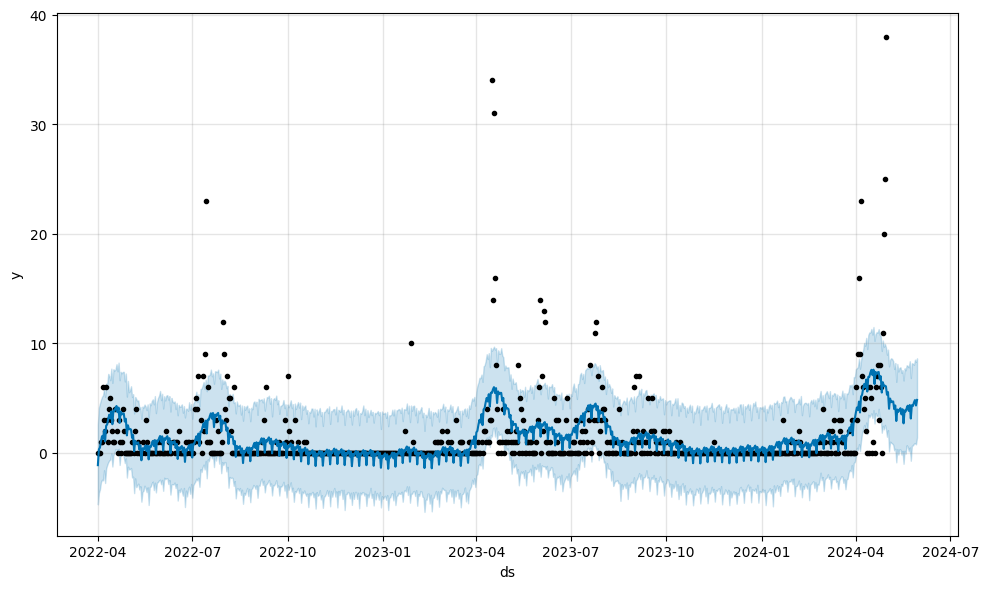

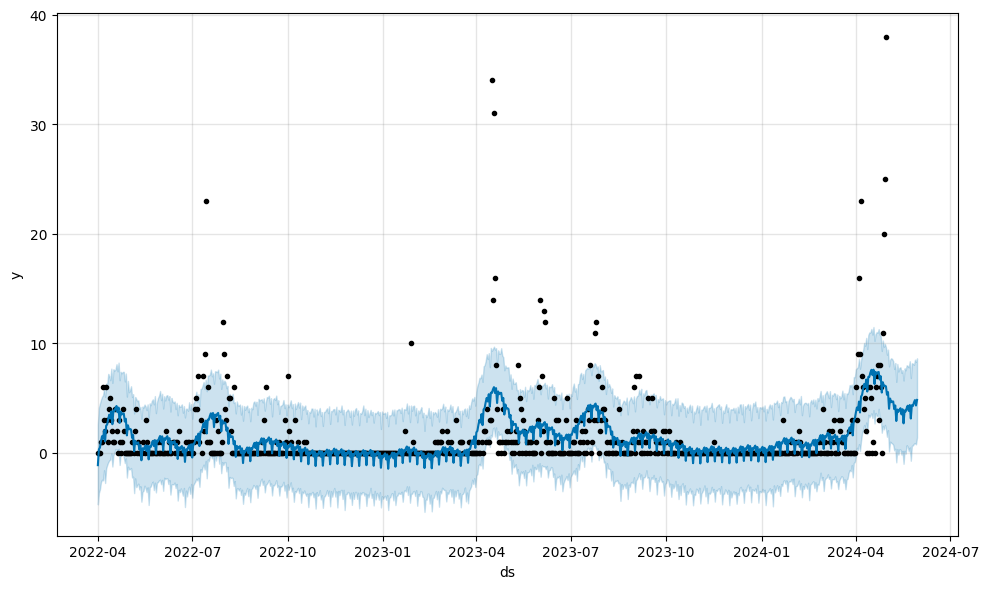

In [9]:
models[3].plot(predictions['17 inch Fan'])

In [102]:
def mean_absolute_percentage_error(y_true, y_pred):
    sum = 0
    for i in range(30):
        diff = np.abs(np.floor(y_pred.iloc[i]) - y_true.iloc[i])
        sum += diff
    print(sum/30)
mean_absolute_percentage_error(sales_data['17 inch Fan'].head(730), predictions['17 inch Fan']['yhat'].head(730))    

1.5


In [107]:
y_true = sales_data['17 inch Fan'].head(730)
y_pred = predictions['17 inch Fan']['yhat'].head(730)

In [108]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print(r2_score(y_true, y_pred))

0.21058371064903925
